# Cough detection
## Authors
- [quirinoc](https://github.com/quirinoc)
- Cabello
- Karol
- Guillermo
- Daniela

## Based on 
### [Music Genre Classification using Hidden Markov Models - Salih Boutadghart](https://blog.goodaudience.com/music-genre-classification-using-hidden-markov-models-4a7f14eb0fd4)

In [2]:
! pip install -r requirements.txt --quiet

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from python_speech_features import mfcc, logfbank
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix
import itertools
import os

In [4]:
sampling_freq, audio = wavfile.read("data/cough/15435__acclivity__goatsinthedust.wav")
mfcc_features = mfcc(audio, sampling_freq)
filterbank_features = logfbank(audio, sampling_freq)

/Users/Quirino/anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [5]:
print ('\nMFCC:\nNumber of windows =', mfcc_features.shape[0])
print ('Length of each feature =', mfcc_features.shape[1])
print ('\nFilter bank:\nNumber of windows =', filterbank_features.shape[0])
print ('Length of each feature =', filterbank_features.shape[1])


MFCC:
Number of windows = 7216
Length of each feature = 13

Filter bank:
Number of windows = 7216
Length of each feature = 26


In [6]:
from random import randint

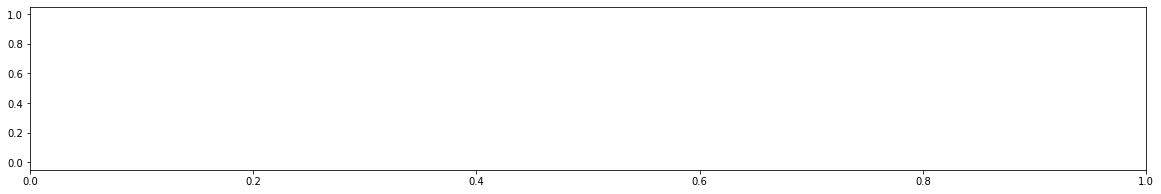

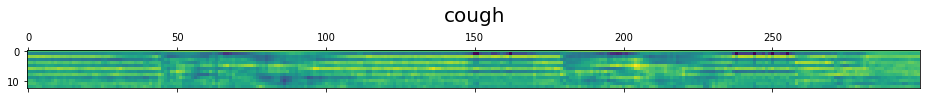

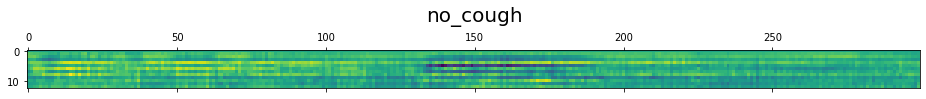

In [7]:
import glob
import os.path as path
from random import randint
categories = ['cough', 'no_cough']
figure = plt.figure(figsize=(20,3))
for idx, category in enumerate(categories): 
    example_data_path = path.join('data', category)
    file_paths = glob.glob(path.join(example_data_path, '*.wav'))
    sampling_freq, audio = wavfile.read(file_paths[randint(0, len(file_paths) - 1)])
    mfcc_features = mfcc(audio, sampling_freq, nfft=1024)
    plt.yscale('linear')
    plt.matshow((mfcc_features.T)[:,:300])
    plt.text(150, -10, category, horizontalalignment='center', fontsize=20)

plt.yscale('linear')
plt.show()

In [8]:
class HMMTrainer(object):
    def __init__(self, model_name='GaussianHMM', n_components=4, cov_type='diag', n_iter=1000):
        self.model_name = model_name
        self.n_components = n_components
        self.cov_type = cov_type
        self.n_iter = n_iter
        self.models = []
        if self.model_name == 'GaussianHMM':
            self.model = hmm.GaussianHMM(n_components=self.n_components,covariance_type=self.cov_type,n_iter=self.n_iter)
        else:
            raise TypeError('Invalid model type') 

    def train(self, X):
        np.seterr(all='ignore')
        self.models.append(self.model.fit(X))
        # Run the model on input data
    def get_score(self, input_data):
        return self.model.score(input_data)

In [11]:
input_folder = 'data'
categories = ['cough','no_cough']

hmm_models = {}

X_data = {}

# Parse the input directory
for category in categories:
    # Get the name of the subfolder
    subfolder = os.path.join(input_folder, category)
    if not os.path.isdir(subfolder):
        print(f'Invalid dir: {subfolder} does not exists!'); break
        
    # Initialize variables
    X = np.array([])
    # Iterate through the audio files (leaving 1 file for testing in each class)
    for filepath in glob.glob(path.join(subfolder, '*.wav')):
        sampling_freq, audio = wavfile.read(filepath)
        # Extract MFCC features
        mfcc_features = mfcc(audio, sampling_freq)
        # Append to the variable X
        if len(X) == 0:
            X = mfcc_features
        else:
            X = np.append(X, mfcc_features, axis=0)
            
    # Train and save HMM models
    hmm_trainer = HMMTrainer(n_components=10)
    X_data[category] = X
    hmm_models[category] = hmm_trainer

ValueError: Unsupported bit depth: the wav file has 24-bit data.

In [ ]:
# Train both models
for category in ['cough', 'no_cough']:
    hmm_models[category].train(X_data[category])

In [ ]:
input_folder = 'data/'
real_labels = []
pred_labels = []
for dirname in os.listdir(input_folder):
    subfolder = os.path.join(input_folder, dirname)
    if not os.path.isdir(subfolder):
        continue
    # Extract the label
    label_real = subfolder[subfolder.rfind('/') + 1:]

    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')][:-1]:
        real_labels.append(label_real)
        filepath = os.path.join(subfolder, filename)
        sampling_freq, audio = wavfile.read(filepath)
        mfcc_features = mfcc(audio, sampling_freq)
        max_score = -9999999999999999999
        output_label = None
    for item in hmm_models:
        hmm_model, label = item
        score = hmm_model.get_score(mfcc_features)
        if score > max_score:
          max_score = score
          output_label = label
pred_labels.append(output_label)